In [ ]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta

#Plotting
import matplotlib.pyplot as plt
%matplotlib widget
import matplotlib.colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts
from physoce import oceans as oc

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt
import Plot_tools as pt

# Data Overview

### Types of Data

The study consisted of deploying a mooring within the Stillwater Kelp forest from July 22nd to September 8th:
- Central mooring was dropped at a location with approximately 10 meters of continuous kelp coverage in all directions
    - 36.56196, -121.94176
- Maximum water depth was 38ft (11.6m), with an average of 34ft (10.4m)
- HOBO temperature logger pro V2's attached to a taut line suspended by subsurface buoy at the mooring weight
    - 7/21/2022 - 9/8/2022
    - 36.56196, -121.94176 (same as central mooring weight
    - Loggers placed along the line at 9.7, 9.4, 9.1, 8, 6, 4, and 2 meters below the surface
    - Each logger sampled continuously at 1 minute intervals
    - Note: loggers from 4-9.7m all out of water from '2022-08-20T16:59:00.000000000'-'2022-08-23T13:20:00.000000000'
- Teledyne RDI ADCP platform placed within relatively clear sand patch within the forest 
    - First deployment
        - 7/21/2022 - 8/14/2022
        - 36.56194210195769, -121.94175918358738
        - Sampled continuously, 1-minute long ensembles averaging 70 pings/minute
        - Bins start at 1m off bottom with .25m spacing between them
    - Second deployment
        - 8/23/2022 - 8/30/2022
        - 36.56194989498659, -121.9417662787946
        - Sampled for 20 minute bursts every hour at 1Hz averaging 12 subpings/second (mode 12)
- Nortek Vector ADV placed in tripod on the seafloor near kelp clusters, velocity transducers were 1m off the floor
    - Sampled for 20 minute bursts every hour at 32Hz
    - 36.56195999999164, -121.94174126537672 (wasn't moved during retrieval and redeployment)
    - First deployment
        - 8/2/2022 - 8/11/2022
    - Second deployment
        - 8/15/2022 - 8/30/2022  
- Monterey Bay Aquarium Research Institute M1 Mooring data (7/21/2022 - 9/9/2022)
- NOAA National Buoy Data Center Statino 46042 (July - September)
- Radial kelp surveys conducted via SCUBA 
    - Each survey consisted of 8 4m x 10m transects run at 0, 45, 90, 135, 180, 225, 270, 315 degree headings
    - Each individual "stipe bundle" within the 4m diameter had its distance and heading on the transect, as well as its diameter recorded
    - A "stipe bundle" is subjectively defined as a any tightly spaced cluster of stipes
        - This sometimes includes multiple kelp individuals that have grown so close together that they are indistinguishable from a single shape

### SWC Mooring Layout

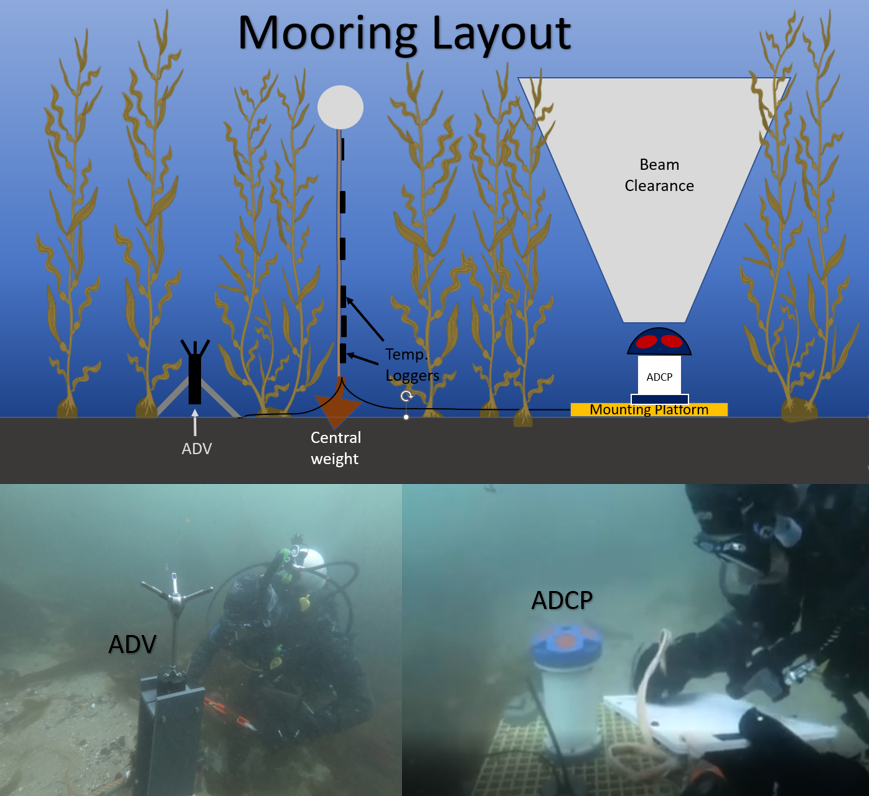

### Import data

In [ ]:
# Temperature data
temp = xr.open_dataset('Temperature/temp_final.nc')

# ADCP data
adcp1 = xr.open_dataset('ADCP/adcp1_qc.nc')
adcp2 = xr.open_dataset('ADCP/adcp2_qc.nc')

# ADV data
adv1 = xr.open_dataset('ADV/adv1IntAvg.nc')
adv2 = xr.open_dataset('ADV/adv2IntAvg.nc')
adv1_raw = xr.open_dataset('ADV/adv1_all.nc')
adv2_raw = xr.open_dataset('ADV/adv2_all.nc')
ws1 = xr.open_dataset('ADV/waveSpectra1.nc')
ws2 = xr.open_dataset('ADV/waveSpectra2.nc')

# M1 data
m1_ns = xr.open_dataset('M1/m1_ns.nc')
m1_ew = xr.open_dataset('M1/m1_ew.nc')
m1_temp = xr.open_dataset('M1/m1_temp.nc')
m1_wind = xr.open_dataset('M1/m1_wind.nc')

# NBDC data
ndbc_46042 = xr.open_dataset('NDBC/ndbc_46042_2022.nc')
ndbc_46239 = xr.open_dataset('NDBC/ndbc_46239_2022.nc')

# Kelp survey data

# Description of Stillwater Cove and Kelp Forest Site

Stillwater Cove (SWC) is a small inlet located at Northern tip of Carmel Bay between Pescadero Point and Arrowhead point. SWC is directly east of Pebble beach, and the two beaches are seperated by a shallow-water, south-running ridge that culminates in a protruding spire of rocks at the offshore boundary known as the Pescadero Rocks. Pesacdero Point, Arrowhead Point, and the Pescadero Rocks all shield SWC from the typical Northwesterly winds that Monterey Bay experiences, but not Westerly or Southerly winds.

From the SWC acccess pier to Pescadero Rocks, there is a shallow water water ridge with rocky substrate that allows a kelp forest to thrive. While this kelp forest is vast and healthy, this site was not chosen because it resides at a range of 2-6 meters in depth and is blocked from offshore waters by the Pescardero Rocks. Measurements of turbulence would likely be too influenced by the bottom boundary layer and surface gravity waves, while the Pescadero Rocks may shelter the site from important offshore processes that this study is interested in analysing. On the Eastern side of SWC, there is another forest that extends from the beach to the tip of Arrowhead point. This forest resides from about 2-11 meters in depth and is more exposed to the offshore waters than the Western site. The topography and rugosity of the forest is also more suitable for the acoustic instruments, with flat and sandy patches of seafloor surounded by rocky substrate that was shorter than the instruments themselves (< 1m).

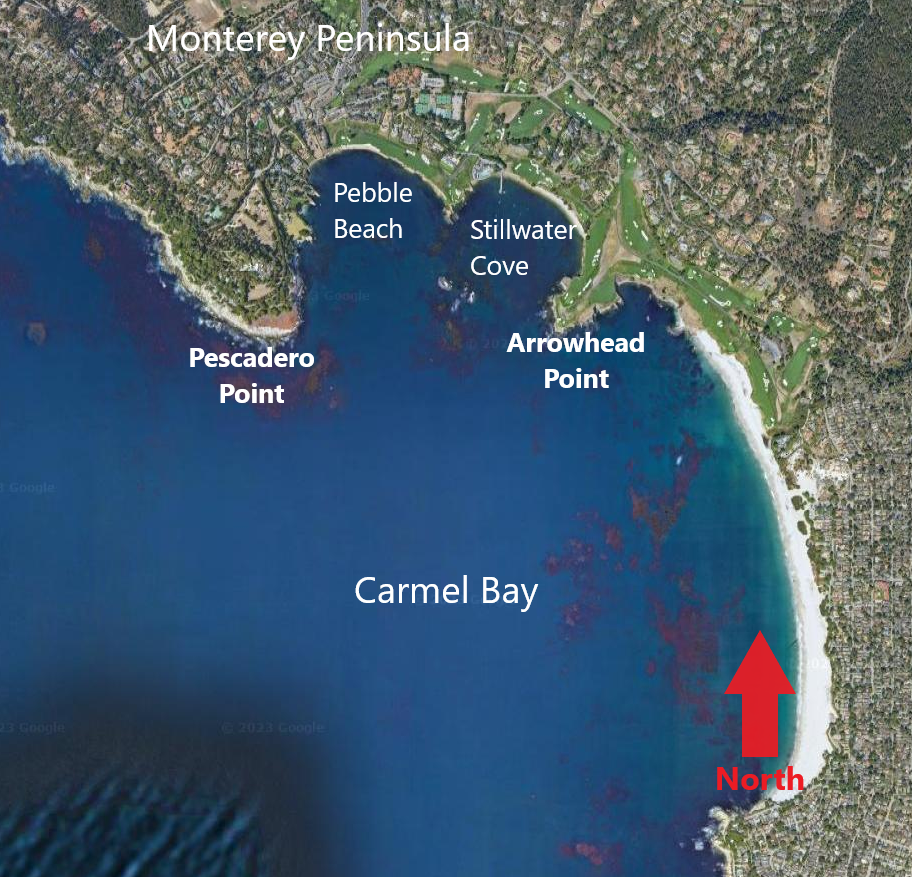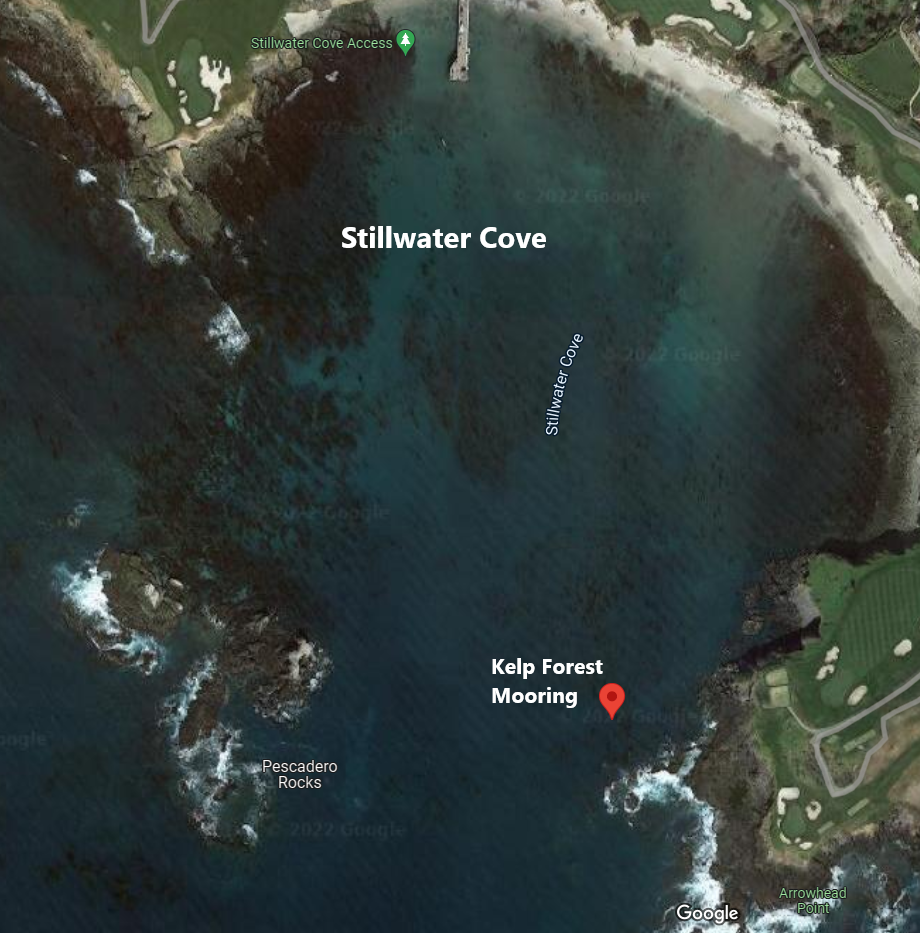

# Exploring SWC Mooring Data

In [3]:
#Plot temperature profile with currents speeds from ADCP and ADV over each of the time series segments

#20-minute averaging interval smooths noise from the data while still resolving important cooling events
rSamp = '60Min'

#Segment 1 (Temperature and adcp data, no adv)
dep1TS = '2022-07-22T00:00:00.000000000' #Start time
dep1TE = '2022-08-02T11:39:00.000000000' #End time

#Segment 2 (Temperature, adcp, and adv data)
dep2TS = '2022-08-02T11:40:00.000000000'
dep2TE = '2022-08-10T23:59:00.000000000'

#Segment 3 (Temperature and adv data, no adcp)
dep3TS = '2022-08-15T08:40:00.000000000'
dep3TE = '2022-08-23T12:00:00.000000000'

#Segment 4 (Temperature, adcp, and adv data)
dep4TS = '2022-08-23T12:40:00.000000000'
dep4TE = '2022-08-30T11:00:00.000000000'

### Hydrodynamic overview
- Temperature profile time series
- Depth averaged ADCP time series
- ADV time series
- Current direction for both
- Averaged over 1-hour

Plotting temperature


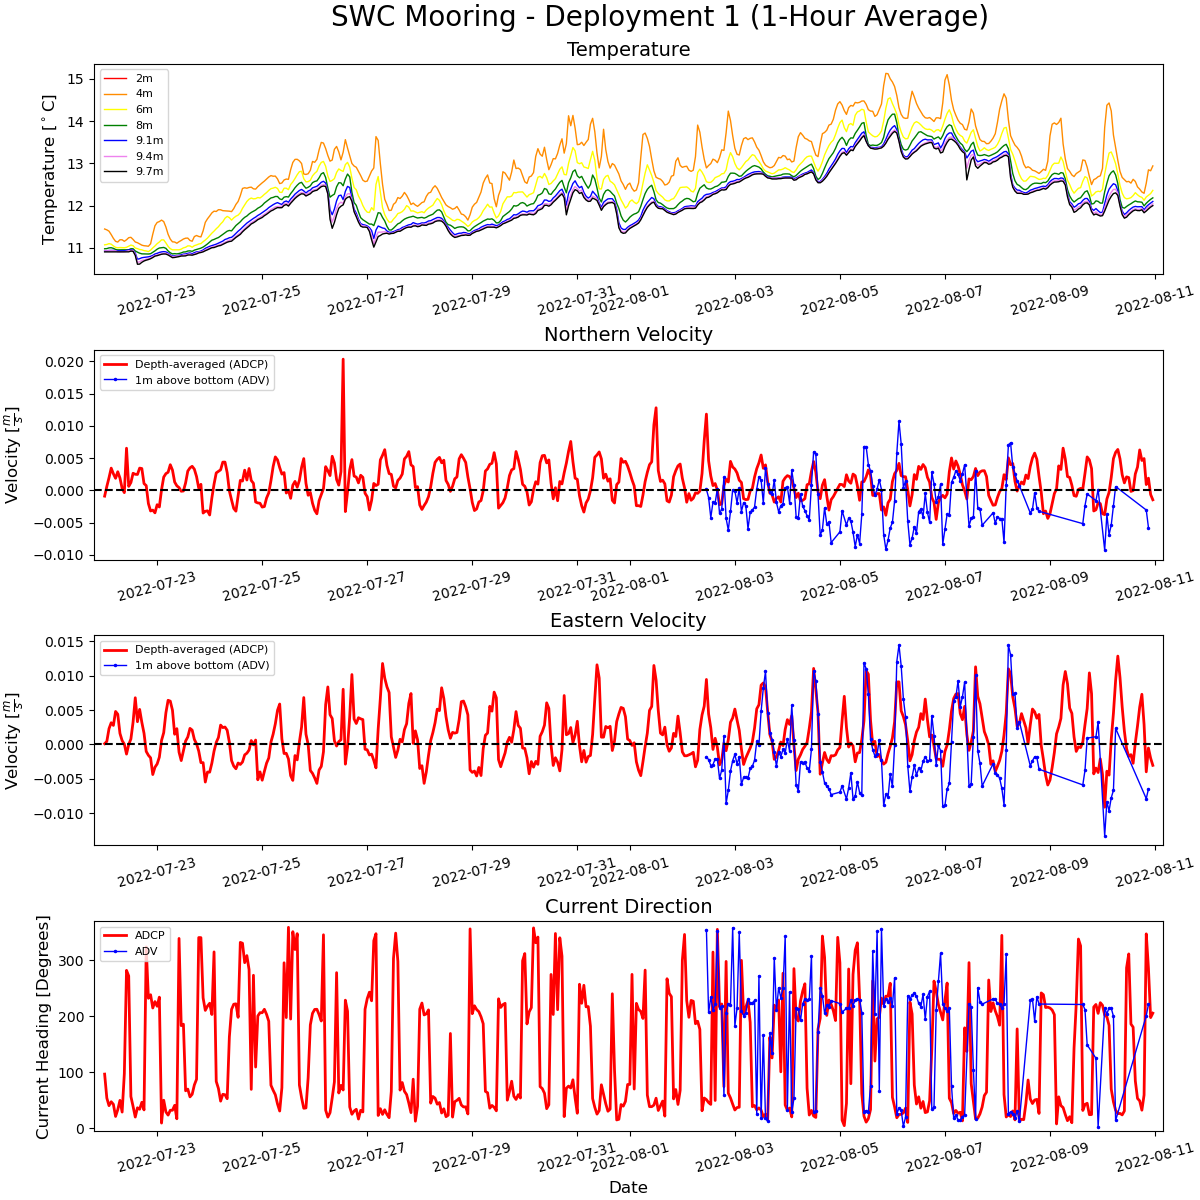

In [4]:
#Deployment 1
pt.overview_plot(temp, adcp1, adv1, startTime = dep1TS, endTime = dep2TE, supTitle = 'SWC Mooring - Deployment 1 (1-Hour Average)', resample = rSamp)#, saveFig = 'Plots/SWC_overview_dep1.png')

Plotting temperature


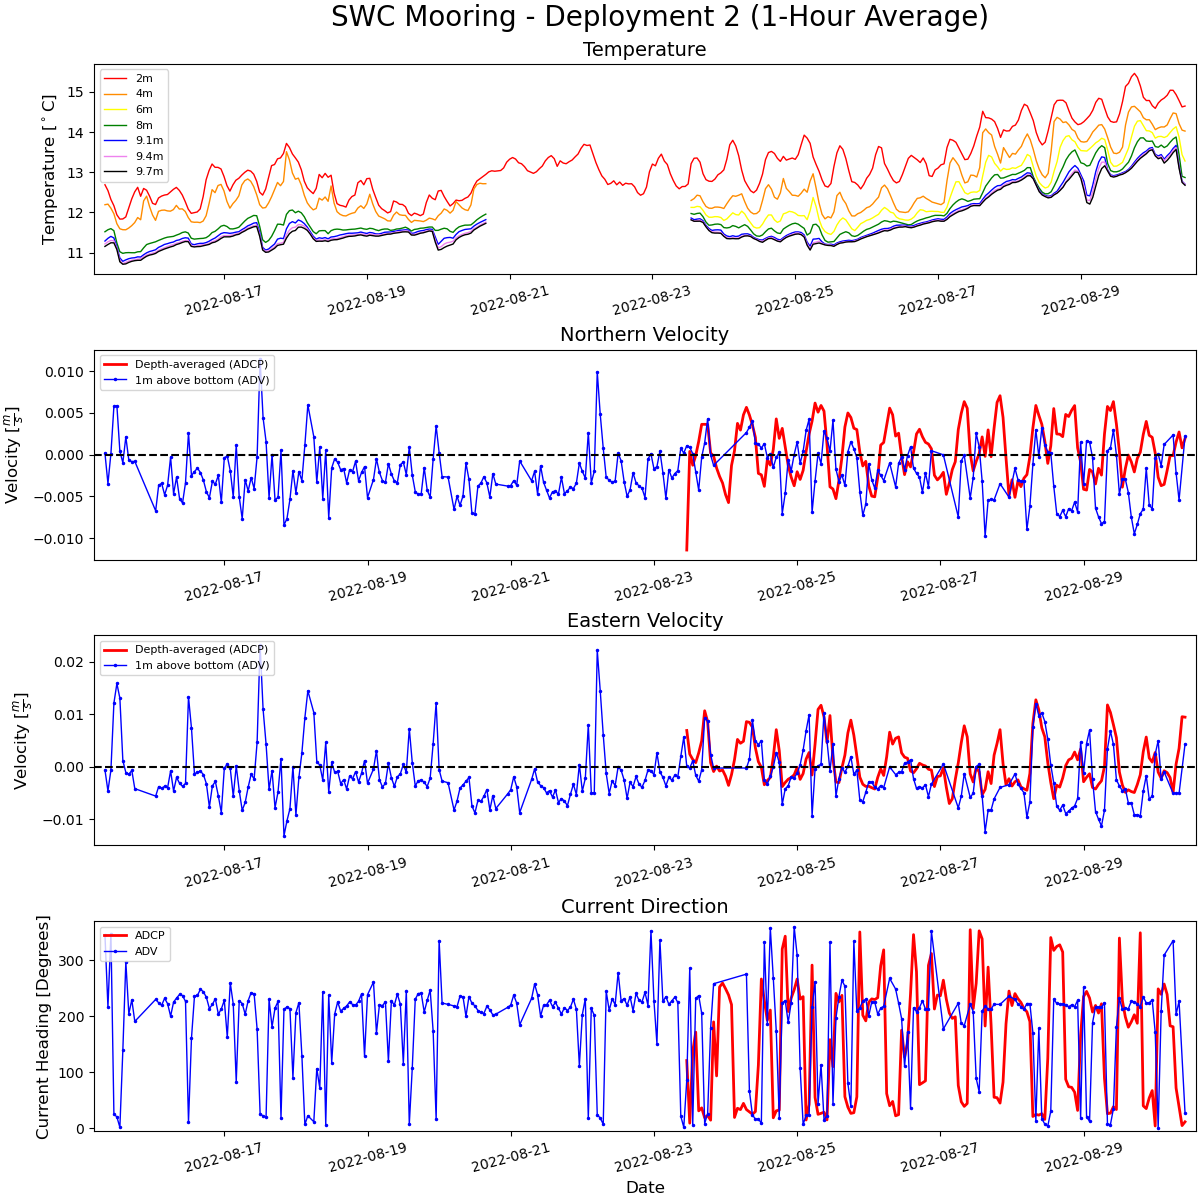

In [5]:
#Deployment 2
pt.overview_plot(temp, adcp2, adv2, startTime = dep3TS, endTime = dep4TE, supTitle = 'SWC Mooring - Deployment 2 (1-Hour Average)', resample = rSamp)#, saveFig = 'Plots/SWC_overview_dep2.png')

### ADCP profiles
- Temperature profile time series
- ADCP profile time series
- Height cutoff at 8m since kelp canopy disturbs data
- Water height from ADCP pressure sensor
- Averaged over 1-hour

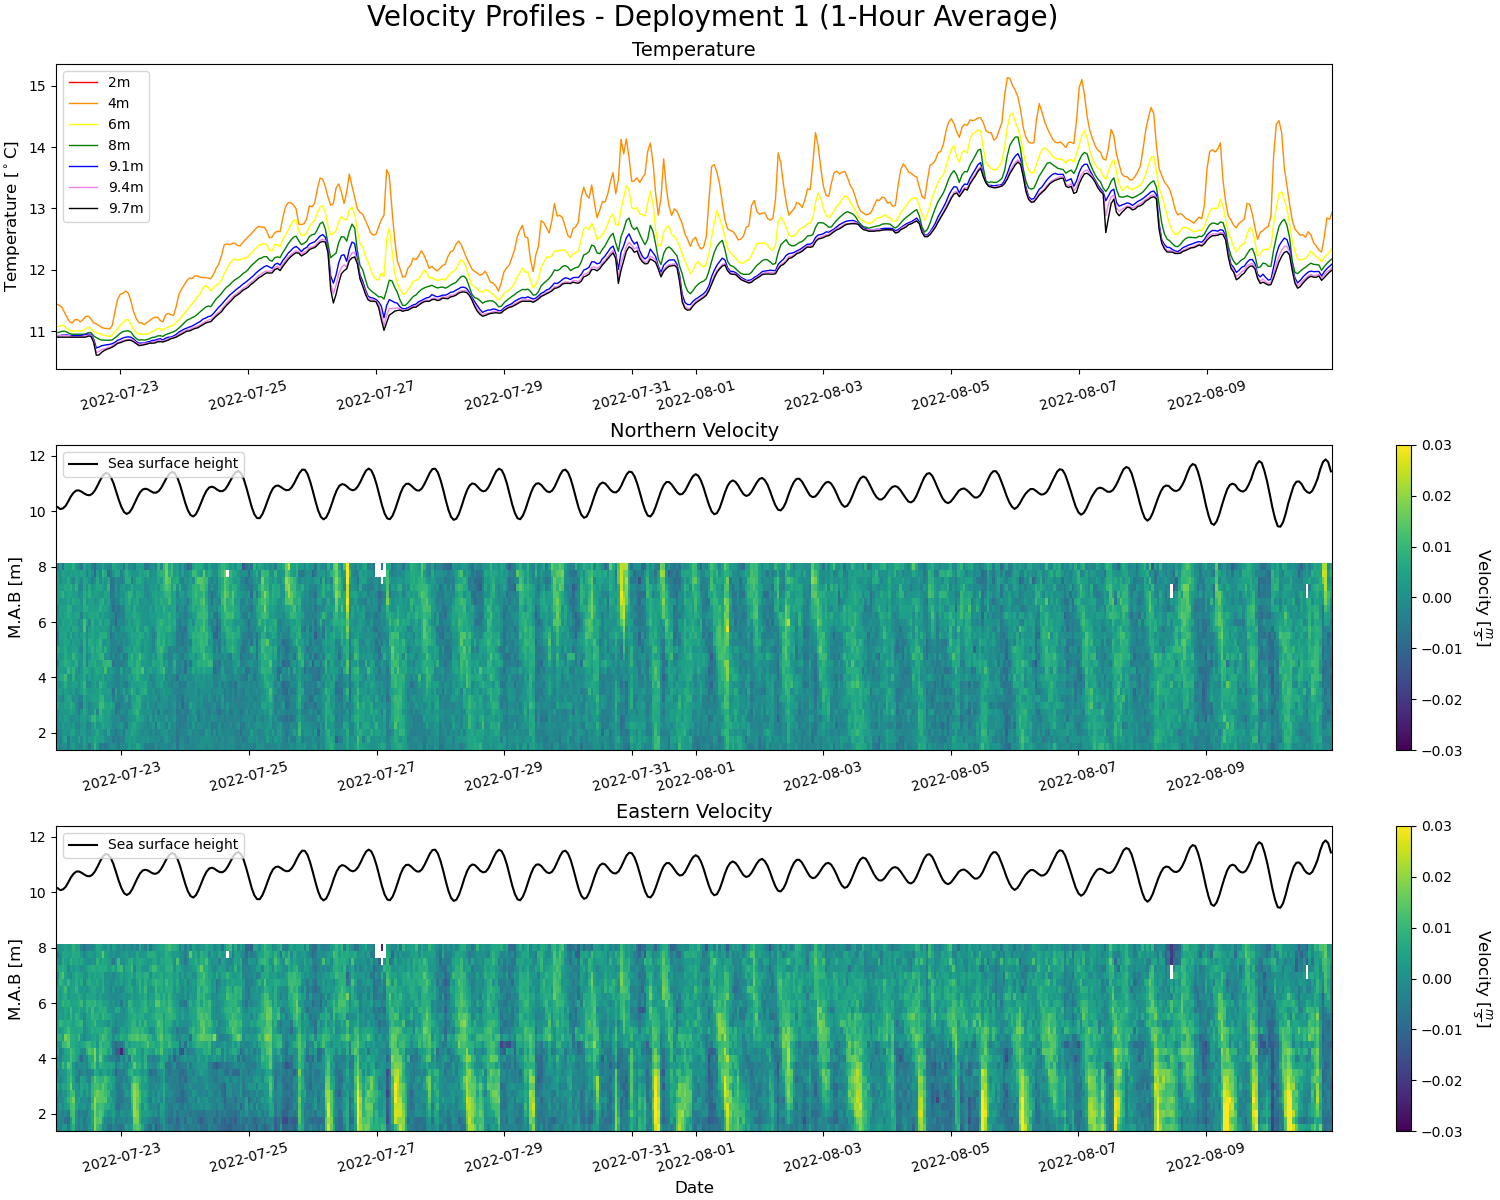

In [87]:
pt.adcp_profile_plot(temp, adcp1, .03, -.03, binNums = [1,28], tStart = dep1TS, tEnd = dep2TE,
                          rSamp = '60Min', flagCutoff = 3, flagPlot = False, supTitle = 'Velocity Profiles - Deployment 1 (1-Hour Average)')#, saveFig = 'Plots/velocity_profiles_dep1.png')

In [ ]:
tStart = '2022-08-23T12:00:00.000000000'
tEnd = '2022-08-30T00:00:00.000000000'
adcp_profile_plot(temp, adcp2, .03, -.03, binNums = [1,28], tStart = tStart, tEnd = tEnd,
                          rSamp = '60Min', flagCutoff = 3, flagPlot = False, supTitle = 'Velocity Profiles - Deployment 2 (1-Hour Average)', saveFig = 'Plots/velocity_profiles_dep2.png')

### Effect of winds on temperature
- Wind data from NDBC station 46042 and M1 buoys
- Depth averaged water temperate from buoys and SWC Mooring
- Westerly winds coincide with cooling temperature
- Temperature rises as these winds dissipate

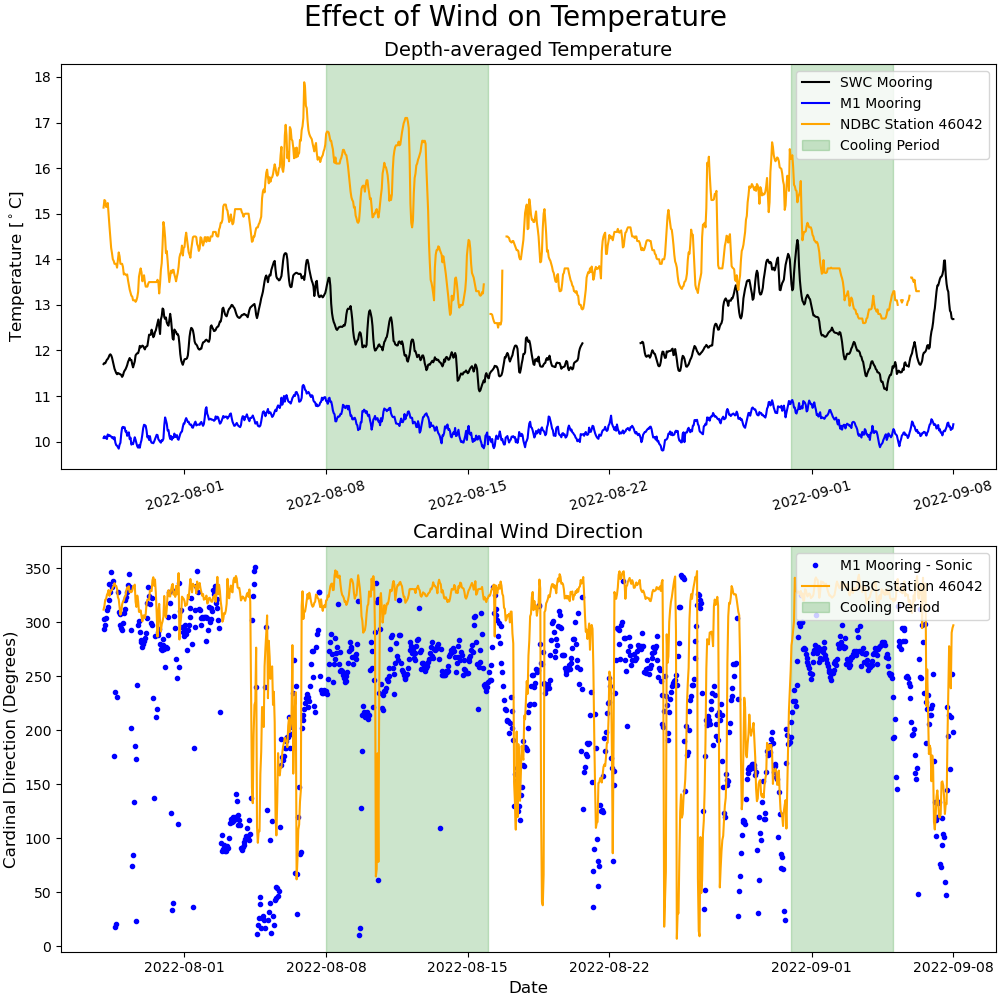

In [6]:
tStart = '2022-07-28T00:00:00.000000000'
tEnd = '2022-09-08T00:00:00.000000000'
rSamp = '60Min'

# create figure and axis objects with subplots()
fig, axs = plt.subplots(2,1,constrained_layout=True, figsize = (10,10))

fig.suptitle('Effect of Wind on Temperature', x = .515, size = 20)

Temp = temp.where(temp.Temperature.isel(depth = 1).isnull() == False)
Temp = Temp.Temperature.mean(dim = 'depth')
Temp = Temp.sel(time = slice(tStart,tEnd)).resample(time = rSamp).mean()
m1WindDir = m1_wind.wind_from_direction_sonic.sel(time = slice(tStart,tEnd)).resample(time = rSamp).mean()
ndbc = ndbc_46042.sel(time = slice(tStart, tEnd)).resample(time = rSamp).mean()
m1Temp = m1_temp.sea_water_temperature.mean(dim = 'z')
m1Temp = m1Temp.sel(time = slice(tStart,tEnd)).resample(time = rSamp).mean()

axs[0].set_title('Depth-averaged Temperature', size = 14)
axs[0].plot(Temp.time, Temp.T, '-k', label = 'SWC Mooring')
axs[0].plot(m1Temp.time, m1Temp.T, '-b', label = 'M1 Mooring')
axs[0].plot(ndbc.time, ndbc.WTMP, 'orange', ms = 2, label = 'NDBC Station 46042')
axs[0].axvspan('2022-08-08T00:00:00.000000000', '2022-08-16T00:00:00.000000000', alpha=0.2, color='green', label = 'Cooling Period')
axs[0].axvspan('2022-08-31T00:00:00.000000000', '2022-09-05T00:00:00.000000000', alpha=0.2, color='green')
axs[0].set_ylabel("Temperature [$^\circ$C]", fontsize=12)
axs[0].tick_params(axis = 'x', labelrotation = 15)
axs[0].legend(loc = 'upper right', fontsize=10)

axs[1].set_title('Cardinal Wind Direction', fontsize=14)
axs[1].plot(m1WindDir.time, m1WindDir, '.b', lw = 2, label = 'M1 Mooring - Sonic')
axs[1].plot(ndbc.time, ndbc.WDIR, 'orange', ms = 2, label = 'NDBC Station 46042')
axs[1].set_xlabel("Date", fontsize = 12)
axs[1].set_ylabel("Cardinal Direction (Degrees)", fontsize=12)
axs[1].set_ylim(-5,370)
axs[1].axvspan('2022-08-08T00:00:00.000000000', '2022-08-16T00:00:00.000000000', alpha=0.2, color='green', label = 'Cooling Period')
axs[1].axvspan('2022-08-31T00:00:00.000000000', '2022-09-05T00:00:00.000000000', alpha=0.2, color='green')
axs[1].legend(loc = 'upper right')

#plt.savefig('Plots/temp_w_wind.png')

### Spectra from all instruments
- Power spectral density plots from each of the instruments in SWC
- Temperature
- U and V velocity from ADCP and ADV
- W velocity from ADV
- Pressure from ADCP and ADV
- Peaks in temperature and ADCP velocity at the tidal consituents
- Peaks in all variables at the 10-8 minute band, unidentified process
- Peak in U,V,W velocity and Pressure from the ADV, likely surface waves

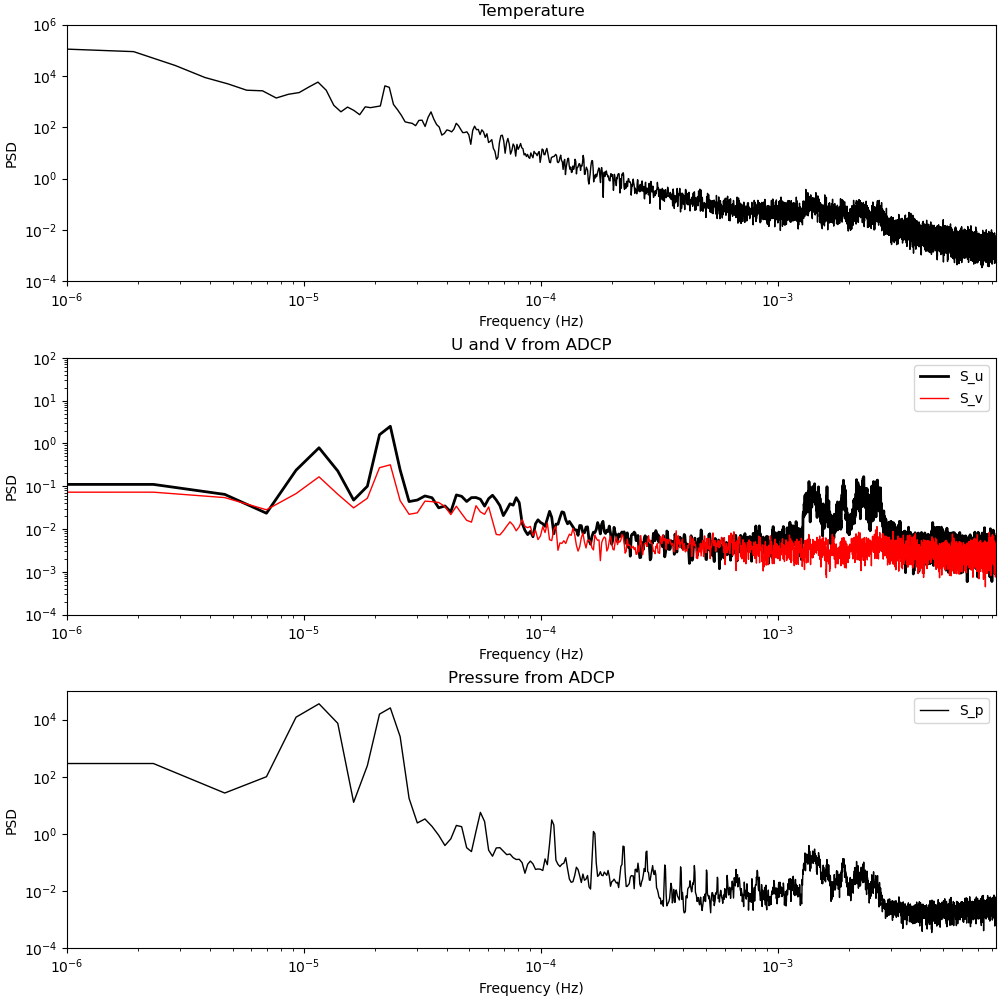

In [50]:
tempDS = temp.copy(deep=True)
temperature = tempDS.TemperatureDA

adcpDS = adcp1.copy(deep=True)
adcpU = adcpDS.AlongshoreDA
adcpV = adcpDS.AcrossShoreDA
adcpP = adcpDS.Depth

nseg = 4

fT, sT = welch(temperature, fs = 1/60, nperseg = len(temperature)/nseg, detrend = 'linear')

fU_adcp, sU_adcp = welch(adcpU, fs = 1/60, nperseg = len(adcpU)/nseg, detrend = 'linear')
fV_adcp, sV_adcp = welch(adcpV, fs = 1/60, nperseg = len(adcpV)/nseg, detrend = 'linear')
fP_adcp, sP_adcp = welch(adcpP, fs = 1/60, nperseg = len(adcpP)/nseg, detrend = 'linear')

fig, ax = plt.subplots(3,1,constrained_layout = True, figsize = (10,10))

ax[0].set_title('Temperature')
ax[0].loglog(fT, sT, '-k', lw = 1)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('PSD')
ax[0].set_ylim(1e-4, 10e5)
ax[0].set_xlim(1e-6, 1/120)

ax[1].set_title('U and V from ADCP')
ax[1].loglog(fU_adcp, sU_adcp, '-k', lw = 2, label = 'S_u')
ax[1].loglog(fV_adcp, sV_adcp, '-r', lw = 1, label = 'S_v')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('PSD')
ax[1].legend(loc = 'upper right')
ax[1].set_ylim(1e-4, 10e1)
ax[1].set_xlim(1e-6, 1/120)

ax[2].set_title('Pressure from ADCP')
ax[2].loglog(fP_adcp, sP_adcp, '-k', lw = 1, label = 'S_p')
ax[2].set_ylim(1e-4, 10e4)
ax[2].set_xlim(1e-6, 1/120)
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('PSD')
ax[2].legend(loc = 'upper right')

In [132]:
nseg = 4
advDS = adv1.copy(deep=True)
advU = advDS.Primary.where((advDS.PrimaryOrig == True) & (advDS.SecondaryOrig == True)).dropna(dim = 'time', how = 'all')
advV = advDS.Secondary.where((advDS.PrimaryOrig == True) & (advDS.SecondaryOrig == True)).dropna(dim = 'time', how = 'all')
advW = advDS.Up.where(advDS.UpOrig == True).dropna(dim = 'time', how = 'all')
advP = advDS.Pressure

fU_adv, sU_adv = welch(advU, fs = 32, nperseg = len(advU)/nseg, detrend = 'linear')
fV_adv, sV_adv = welch(advV, fs = 32, nperseg = len(advV)/nseg, detrend = 'linear')
fW_adv, sW_adv = welch(advW, fs = 32, nperseg = len(advW)/nseg, detrend = 'linear')
fP_adv, sP_adv = welch(advP, fs = 32, nperseg = len(advP)/nseg, detrend = 'linear')

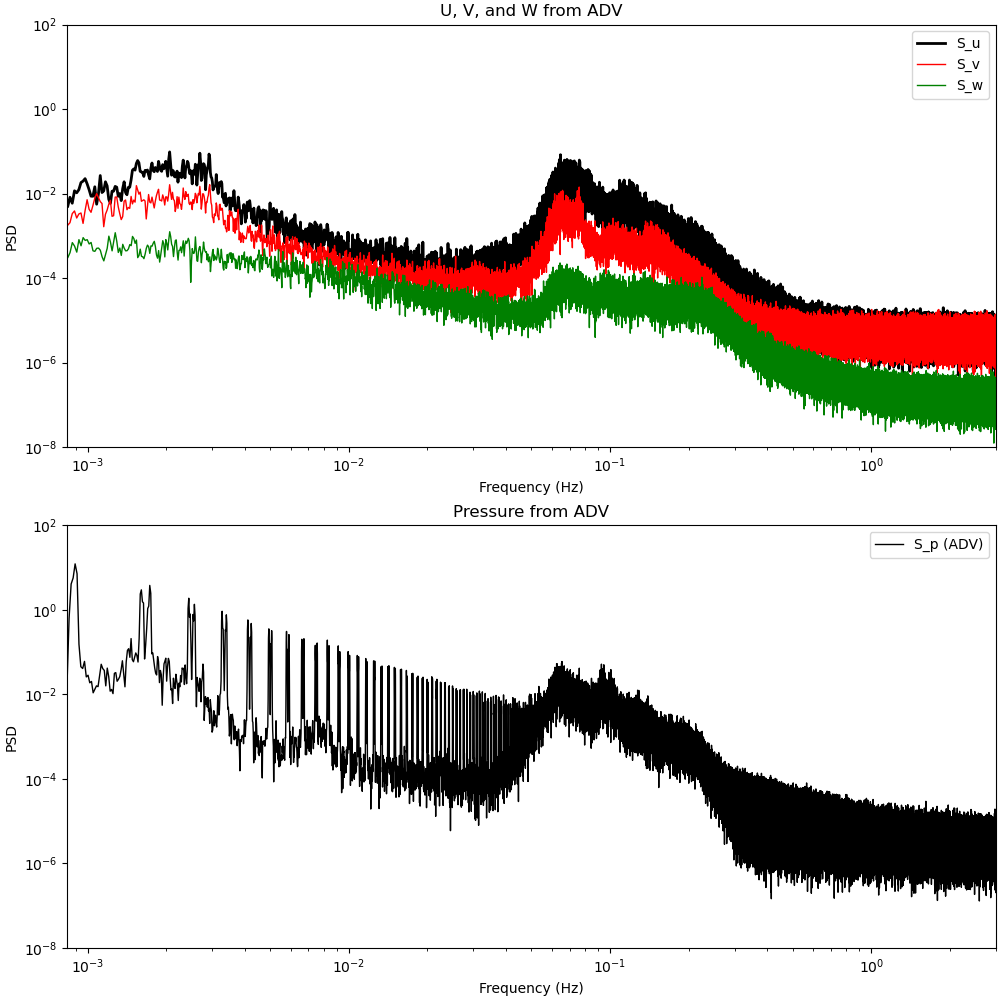

In [133]:
fig, ax = plt.subplots(2,1,constrained_layout = True, figsize = (10,10))

ax[0].set_title('U, V, and W from ADV')
ax[0].loglog(fU_adv, sU_adv, '-k', lw = 2, label = 'S_u')
ax[0].loglog(fV_adv, sV_adv, '-r', lw = 1, label = 'S_v')
ax[0].loglog(fW_adv, sW_adv, '-g', lw = 1, label = 'S_w')
ax[0].set_ylim(1e-8, 10e1)
ax[0].set_xlim(8.33e-4, 3)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('PSD')
ax[0].legend(loc = 'upper right')

ax[1].set_title('Pressure from ADV')
ax[1].loglog(fP_adv, sP_adv, '-k', lw = 1, label = 'S_p (ADV)')
ax[1].set_ylim(1e-8, 10e1)
ax[1].set_xlim(8.33e-4, 3)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('PSD')
ax[1].legend(loc = 'upper right')

### Cooling Events

In [154]:
tempDS = temp.copy(deep=True)
adcpDS = adcp1.copy(deep=True)
tStart = '2022-07-22T00:00:00.000000000'
tEnd = '2022-08-11T00:00:00.000000000'

T = temp.TemperatureDA.sel(time = slice(tStart, tEnd))
T = T.where(T.time.isin(H.time), drop = True).values
dT = np.diff(T, prepend = T[0])
H = adcpDS.Depth.sel(time = slice(tStart, tEnd)).values
dH = np.diff(H, prepend = H[0])
East = adcpDS.EastDA.sel(time = slice(tStart, tEnd)).values
dEast = np.diff(East, prepend = East[0])
North = adcpDS.NorthDA.sel(time = slice(tStart, tEnd)).values
dNorth = np.diff(North, prepend = North[0])

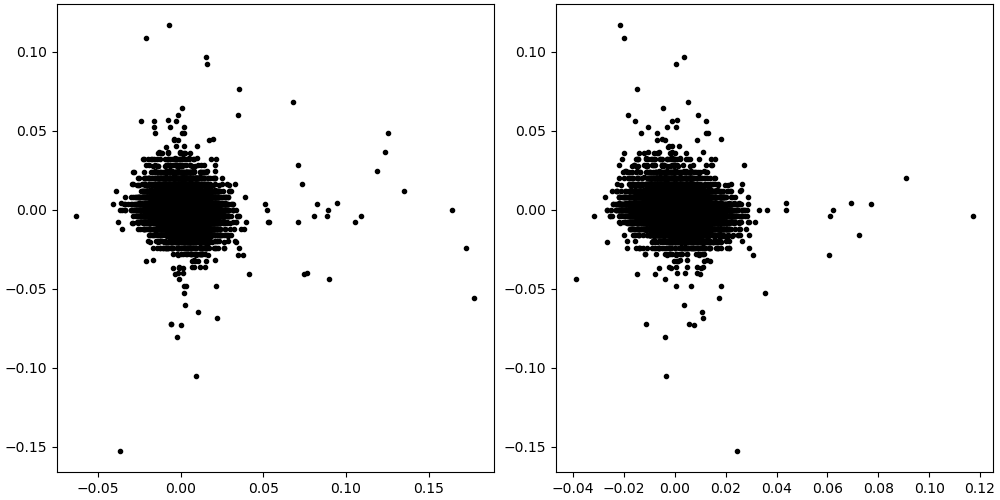

In [165]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (10,5))

ax[0].plot(North, dT, '.k')

ax[1].plot(East, dT, '.k')

# Waves

### Comparing offshore waves with SWC ADV data
- NDBC stations 46042 and 46239 record wave height, direction, and period of offshore waves near SWC
- SWC ADV records pressure at 32 hz for accurate measurements of waves
- Surface gravity waves affect pressure but turbulence does not
- Converting pressure spectra to vertical velocity shows where surface waves are concentrated and estimates their period
- Observe time series of pressure spectra with respect to offshore wave properties

In [ ]:
Rho1 = temp.Rho.sel(time = slice(adv1.time[0],adv1.time[-1])).mean()
Rho2 = temp.Rho.sel(time = slice(adv2.time[0],adv2.time[-1])).mean()
fs = 32
rSamp = '60Min'
nperseg = fs * 60

ws1 = vt.waveData(adv1, Rho1, fs, rSamp, nperseg, ZpOffset = .578, ZvOffset = .824)
ws1.to_netcdf('ADV/waveSpectra1.nc')

ws2 = vt.waveData(adv2, Rho2, fs, rSamp, nperseg, ZpOffset = .578, ZvOffset = .824)
ws2.to_netcdf('ADV/waveSpectra2.nc')

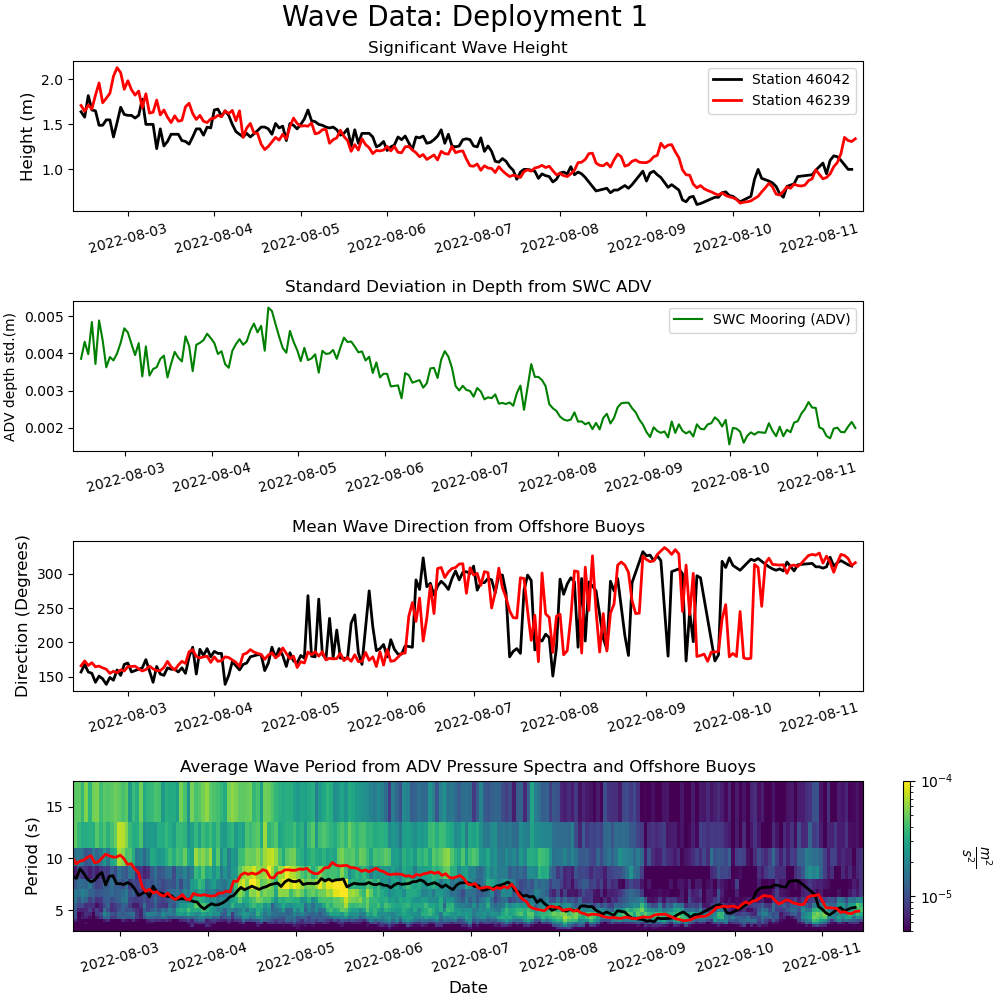

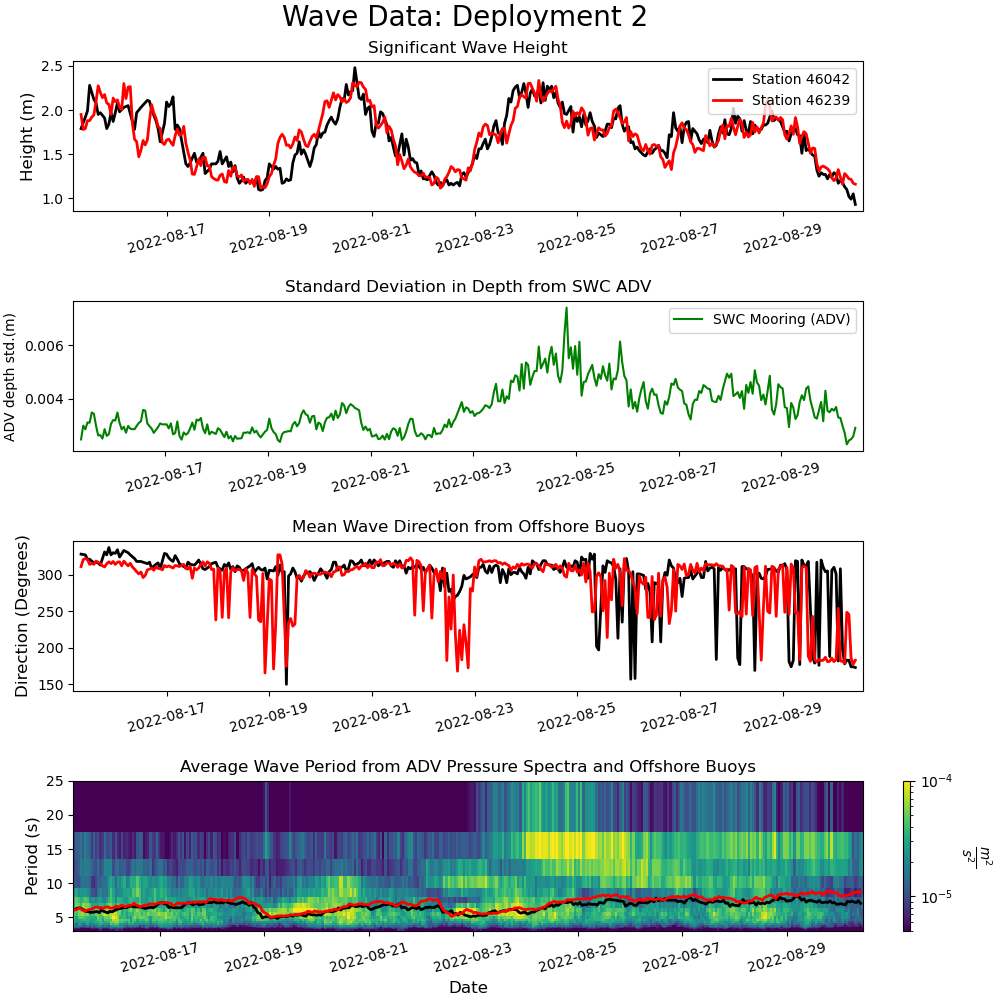

In [120]:
#Look at spectra for deployment 1
tStart = '2022-08-02T11:40:00.000000000'
tEnd = '2022-08-11T11:00:00.000000000'
rSamp = '60Min'
wave_plot(ws1, ndbc_46042, ndbc_46239, tStart, tEnd, rSamp, T_Range = [3, 17.5], supTitle = 'Wave Data: Deployment 1', saveFig = 'Plots/wave_overview_dep1.png')

#Now for deployment 2
tStart2 = '2022-08-15T08:40:00.000000000'
tEnd2 = '2022-08-30T10:40:00.000000000'
rSamp = '60Min'
wave_plot(ws2, ndbc_46042, ndbc_46239, tStart2, tEnd2, rSamp, T_Range = [3, 25], supTitle = 'Wave Data: Deployment 2', saveFig = 'Plots/wave_overview_dep2.png')

Text(510.3244949494949, 0.5, 'Mean wave direction (degrees)')

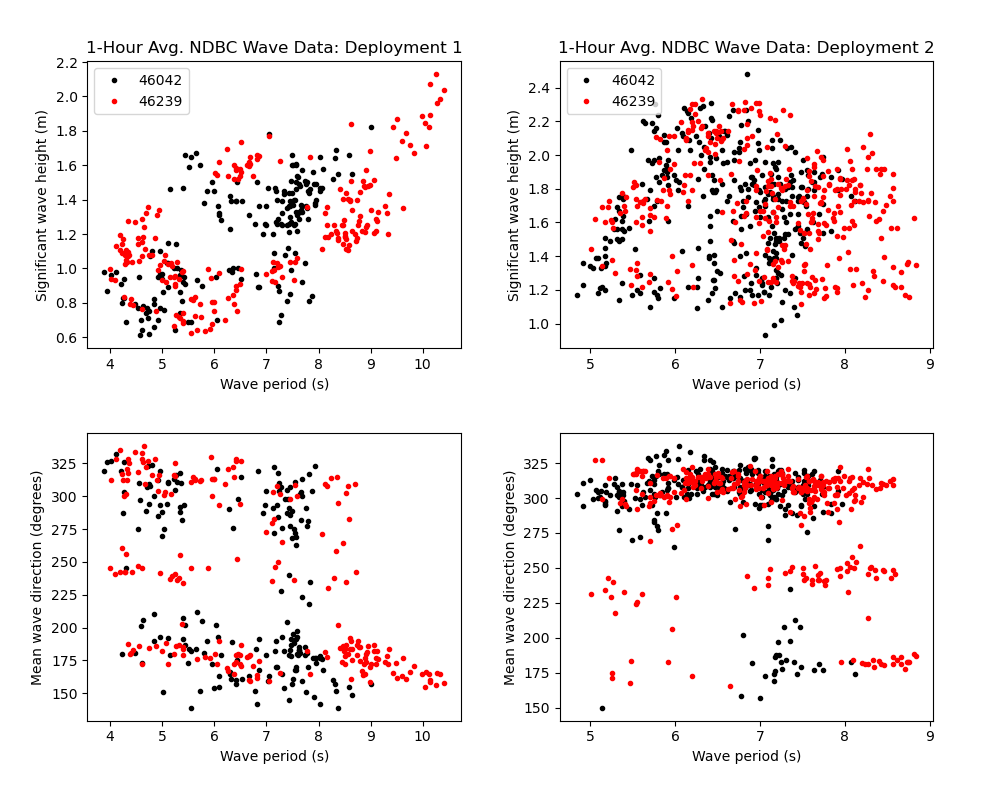

In [28]:
fig, axs = plt.subplots(2,2, constrained_layout = True, figsize = (10,8))

fig.tight_layout(pad = 4)

axs[0,0].set_title('1-Hour Avg. NDBC Wave Data: Deployment 1')
axs[0,0].plot(APD_46042, WVHT_46042, '.k', label = '46042')
axs[0,0].plot(APD_46239, WVHT_46239, '.r', label = '46239')
axs[0,0].set_ylabel('Significant wave height (m)')
axs[0,0].set_xlabel('Wave period (s)')
axs[0,0].legend(loc = 'upper left')

axs[0,1].set_title('1-Hour Avg. NDBC Wave Data: Deployment 2')
axs[0,1].plot(APD_46042_2, WVHT_46042_2, '.k', label = '46042')
axs[0,1].plot(APD_46239_2, WVHT_46239_2, '.r', label = '46239')
axs[0,1].set_ylabel('Significant wave height (m)')
axs[0,1].set_xlabel('Wave period (s)')
axs[0,1].legend(loc = 'upper left')

'''axs[1,0].plot(MWD_46042, WVHT_46042, '.k', label = '46042')
axs[1,0].plot(MWD_46239, WVHT_46239, '.r', label = '46239')
axs[1,0].set_ylabel('Significant wave height (m)')
axs[1,0].set_xlabel('Mean wave direction (degrees)')

axs[1,1].plot(MWD_46042_2, WVHT_46042_2, '.k', label = '46042')
axs[1,1].plot(MWD_46239_2, WVHT_46239_2, '.r', label = '46239')
axs[1,1].set_ylabel('Significant wave height (m)')
axs[1,1].set_xlabel('Mean wave direction (degrees)')'''

axs[1,0].plot(APD_46042, MWD_46042, '.k', label = '46042')
axs[1,0].plot(APD_46239, MWD_46239, '.r', label = '46239')
axs[1,0].set_xlabel('Wave period (s)')
axs[1,0].set_ylabel('Mean wave direction (degrees)')

axs[1,1].plot(APD_46042_2, MWD_46042_2, '.k', label = '46042')
axs[1,1].plot(APD_46239_2, MWD_46239_2, '.r', label = '46239')
axs[1,1].set_xlabel('Wave period (s)')
axs[1,1].set_ylabel('Mean wave direction (degrees)')

Significant wave height, mean wave direction, and average wave period data are retreived from NDBC stations 46042 and 46239, which are located offshore in Northern Monterey Bay and Big Sur, respectively. The seafloor-mounted ADV located at the SWC mooring recorded pressure at 32 Hz for 20-minute bursts every hour, capturing pressure fluctuations well within the surface gravity wave band. Pressure spectra generated from the ADV data can be converted to vertical velocity spectra at the depth of the instrument using linear wave theory. This method allows the specific peak in variability caused by surface waves to be isolated from other physical processes, such as internal waves and tides at the low frequency bands, and turbulence at the high frequency bands.The wave spectra generated from the ADV data is made into a time series, where spectral peaks in vertical velocity can be viewed by their period. The standard deviation of depth recorded by the ADV is used as a proxy for trends in sea level change, though it does not indicate the true wave height.

Despite the two buoy stations being spatially seperated by Monterey Peninsula and recording near drastically different coastal topographies, their time series of wave data follow each other closesly. Likewise, the offshore wave period appears to match the peaks in vertical velocity spectra captured by the ADV in SWC. During the first deployment, the ADV data displays a spectral peak around the 10s period, which is reflected by the data from station 46239 (Big Sur). Over the course of a couple days, the peak wave period decreases to 7.5s, before hitting a floor of 5s. During the first week of ADV deployment 2, the spectral peak maintains a period between 5 and 10 seconds, which is also closely followed by the offshore buoy data. The latter half of this deployment shows the spectral peak broadening to a 15s period, while a second peak is present near the 5s band. While the offshore data does not exactly follow the highest spectra peaks during this time, it does shift to a slightly higher period, staying well within the surface wave band recorded by the ADV. 

While the offshore wave period appears to be a good indicator of wave period within SWC, offshore wave height and direction show little to no correlation with wave period over the course of both deployments. While there does appear to be a positive correlation between significant wave height and wave period during deployment 1, this relationship is absent during deployment 2, making any potential relationships inconclusive. Concerning inter-variable relationships within SWC, the proxy for wave height using the standard deviation of depth coincides well with SWC wave period. This is to be expected since the spectrum of wave period is a function of variability in the pressure data.

### Wave orbital velocity
- ADV records velocity at 32 hz for accurate measurements of velocity oscillations
- Standard deviation of horizontal velocity can be used as a proxy for orbital velocity
- Using offshore wave data, the hypothetical orbital wave velocity at SWC depth can be estimated
- Compare the two to assess wave orbital velocity in SWC

In [234]:
tStart = '2022-08-02T11:40:00.000000000'
tEnd = '2022-08-11T11:00:00.000000000'
tStart2 = '2022-08-15T08:40:00.000000000'
tEnd2 = '2022-08-30T10:40:00.000000000'

rSamp = '60Min'

MWD_46239 = ndbc_46239.MWD.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean()
WVHT_46239 = ndbc_46239.WVHT.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean()
APD_46239 = ndbc_46239.APD.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean()
MWD_46042 = ndbc_46042.MWD.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean()
WVHT_46042 = ndbc_46042.WVHT.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean()
APD_46042 = ndbc_46042.APD.sel(time = slice(tStart, tEnd)).resample(time = rSamp, offset = '40Min').mean()

MWD_46239_2 = ndbc_46239.MWD.sel(time = slice(tStart2, tEnd2)).resample(time = rSamp, offset = '40Min').mean()
WVHT_46239_2 = ndbc_46239.WVHT.sel(time = slice(tStart2, tEnd2)).resample(time = rSamp, offset = '40Min').mean()
APD_46239_2 = ndbc_46239.APD.sel(time = slice(tStart2, tEnd2)).resample(time = rSamp, offset = '40Min').mean()
MWD_46042_2 = ndbc_46042.MWD.sel(time = slice(tStart2, tEnd2)).resample(time = rSamp, offset = '40Min').mean()
WVHT_46042_2 = ndbc_46042.WVHT.sel(time = slice(tStart2, tEnd2)).resample(time = rSamp, offset = '40Min').mean()
APD_46042_2 = ndbc_46042.APD.sel(time = slice(tStart2, tEnd2)).resample(time = rSamp, offset = '40Min').mean()

advDS = adv1.copy(deep=True)

E = advDS.East.where((advDS.EOrig == True) & (advDS.NOrig == True)).dropna(dim = 'time', how = 'all')
N = advDS.North.where((advDS.EOrig == True) & (advDS.NOrig == True)).dropna(dim = 'time', how = 'all')
hVel = np.sqrt((E**2) + (N**2))
obWave = hVel.resample(time = rSamp).std()
obWave = obWave.where(obWave > .01, drop = True)
ubWave = oc.ubwave(ws1.Hstd*20, APD_46239, 10) #If proxy waveheight from ADV is multiplied by 20,
                                               #it matches the ubWave function very well

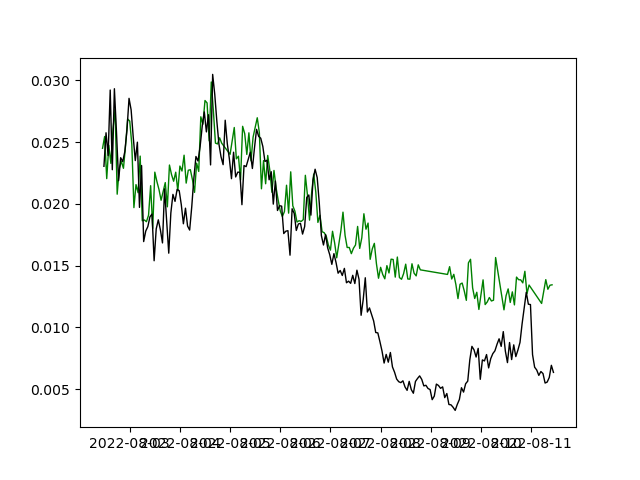

In [235]:
plt.figure()
plt.plot(obWave.time, obWave, '-g', lw = 1)
plt.plot(ubWave.time, ubWave, '-k', lw = 1)

### Turbulent Kintetic Energy Dissipation Rate ($\epsilon$)
- Any velocity measurements with a Signal-to-noise ratio below 10 or a Correlation below 60% on any of the three beams is removed
- ADV data is despiked using an exanding ellipsoid algorithm outlined in Wheeler and Giddings (2023)
- The data gaps created by the quality control and despiking process are then linearly interpolated over gaps <= 1 second, with larger gaps being filled in with the average of the orginal values present within the gap
- These "fixed" data points are labelled as "unoriginal", and a ratio of unoriginal to original data points is recorded for future quality control
- $\epsilon$ is estimated from the vertical velocity spectra of 20-minute ADV bursts with an unoriginal ratio < 0.25
- Each burst was filtered using a Hann window with 60-second segments and 50% overlap resulting in 106 degrees of freedom (Thomson and Emery, 2014)
- Locating the inertial subrange (ISR):
    - Initial boundaries of the ISR were estimated as the peak surface wave frequency (low boundary) and the instrument noise floor (high boundary), which was consistently set at 3.5 Hz
    - To estimate the peak wave frequency, pressure spectra recorded by the ADV was converted to vertical velocity via linear wave theory
    - Within these boundaries, every sequence of points with a minimum range of 1Hz was fit with a power-law curve and a power-law with fixed -5/3 slope, both using least squares error
- Calculating $\epsilon$:
    - $\epsilon(\omega)$ = ${\langle\frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)}\rangle} ^\frac{3}{2}$
    - $S_{ww}(\omega)$ = Vertical velocity spectra at omega
    - $\omega$ = radian frequency being evaluated
    - $\alpha$ = 1.5 (Kolmogoroff's constant)
    - $J_{33}(\omega)$ = integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities
    - $\epsilon$ is estimated over all radian frequencies within proposed inertial subrange
- The $\epsilon$ estimates were then run through a series of quality control tests:
    - The intercept of the fit is > standard error in the intercept (Jones and Monosmith, 2008)
    - The average of the noise floor magnitude < half the magnitude of spectrum at lower ISR boundary (Gerbi et al. 2009)
    - The slope ($\mu$) and slope error($\mu_{err}$) of the fit fall within acceptable boundaries:
        - $\mu$ - 2$\mu_{err}$ - .06 < -5/3 < $\mu$ + 2$\mu_{err}$ + .06 (Feddersen, 2010)
        - $\frac{|\mu + \frac{5}{3}|}{\mu_{err}}$ < 1.960 (Wheeler and Giddings, 2023)
    - Linear regression of $\epsilon(\omega)$ over suggested ISR has a slope that is statiscally indistinguishable from 0
- From the suggested ISR ranges that pass all tests, the the fit with the lowest root mean square error from the -5/3 fit was chosen as the best
- From this best fit, the mean of $\epsilon$ over the ISR is calculated and used as the final value of $\epsilon$ for the data burst

In [ ]:
# Turbulent dissipation data
eps1 = xr.open_dataset('Dissipation/eps1IntAvg.nc')
eps2 = xr.open_dataset('Dissipation/eps2IntAvg.nc')

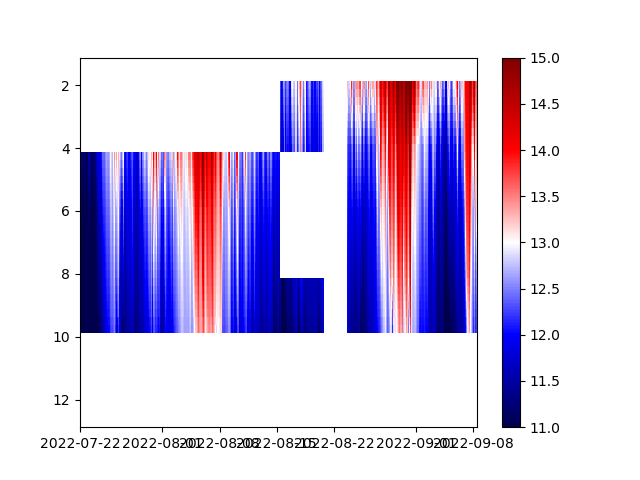